In [31]:
import tensorflow as tf
import numpy as np
import numpy.random as rnd
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [32]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [33]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [34]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [57]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005,
                      activation=tf.nn.elu, seed=42):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            activation=activation,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=None, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                #print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            if epoch % 500 == 0:
                print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [7]:
hidden_output1, W1, b1, W8, b8 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=10, batch_size=150)
hidden_output2, W2, b2, W7, b7 = train_autoencoder(hidden_output1, n_neurons=150, n_epochs=10, batch_size=150)
hidden_output3, W3, b3, W6, b6 = train_autoencoder(hidden_output2, n_neurons=100, n_epochs=10, batch_size=150)
_, W4, b4, W5, b5 = train_autoencoder(hidden_output3, n_neurons=100, n_epochs=10, batch_size=150)

0 Train MSE: 0.0183982
1 Train MSE: 0.0177385
2 Train MSE: 0.0196133
3 Train MSE: 0.0193563
4 Train MSE: 0.0190451
5 Train MSE: 0.0190056
6 Train MSE: 0.0193961
7 Train MSE: 0.0192289
8 Train MSE: 0.0202561
9 Train MSE: 0.0199055
0 Train MSE: 0.00380842
1 Train MSE: 0.00409988
29% Train MSE: 0.00431585
3 Train MSE: 0.00434471
4 Train MSE: 0.00419277
5 Train MSE: 0.00429302
6 Train MSE: 0.00422816
7 Train MSE: 0.00431629
8 Train MSE: 0.00424535
9 Train MSE: 0.00406624
0 Train MSE: 0.00200147
1 Train MSE: 0.00225636
29% Train MSE: 0.00216797
3 Train MSE: 0.00219349
4 Train MSE: 0.00235258
5 Train MSE: 0.00213609
6 Train MSE: 0.00228164
7 Train MSE: 0.00216262
8 Train MSE: 0.0023144
9 Train MSE: 0.00219831
0 Train MSE: 0.00135469
1 Train MSE: 0.00145265
2 Train MSE: 0.00159484
3 Train MSE: 0.00170018
4 Train MSE: 0.00181245
5 Train MSE: 0.00158198
6 %Train MSE: 0.00162535
7 Train MSE: 0.00183296
89% Train MSE: 0.00165678
9 Train MSE: 0.00177484


In [8]:
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
hidden4 = tf.nn.elu(tf.matmul(hidden3, W4) + b4)
hidden5 = tf.nn.elu(tf.matmul(hidden4, W5) + b5)
hidden6 = tf.nn.elu(tf.matmul(hidden5, W6) + b6)
hidden7 = tf.nn.elu(tf.matmul(hidden6, W7) + b7)
outputs = tf.matmul(hidden7, W8) + b8

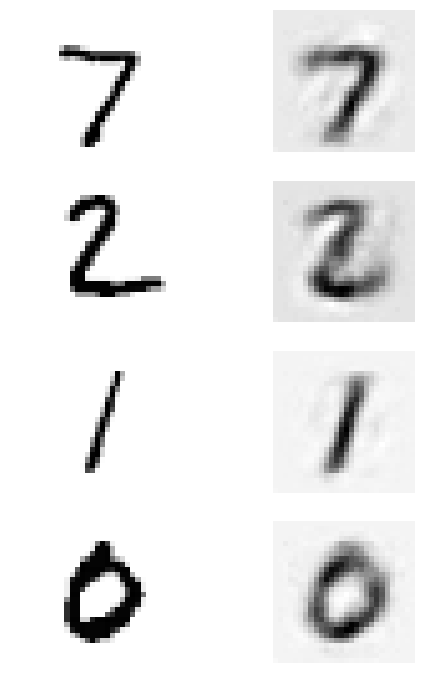

In [9]:
show_reconstructed_digits(X, outputs, n_test_digits = 4)

In [29]:
x_train = np.genfromtxt('data/data_wt/sp500_wt.csv', delimiter=',', dtype=None, names=True)
x_train = [list(item) for item in x_train]
x_train = np.array(x_train)
print(x_train.shape)

(2079, 21)


In [ ]:
# Following the paper's instructions
BATCH_SIZE = 60
N_EPOCHS = 5000
ACTIVATION = tf.nn.sigmoid
LEARNING_RATE = 0.05

hidden_output1, W1, b1, W8, b8 = train_autoencoder(x_train, 
                                                   n_neurons=10, 
                                                   n_epochs=N_EPOCHS, 
                                                   batch_size=BATCH_SIZE, 
                                                   learning_rate=LEARNING_RATE,
                                                   activation=ACTIVATION)
print("-------------------------------")
hidden_output2, W2, b2, W7, b7 = train_autoencoder(hidden_output1, 
                                                   n_neurons=10, 
                                                   n_epochs=N_EPOCHS, 
                                                   batch_size=BATCH_SIZE,
                                                   learning_rate=LEARNING_RATE,
                                                   activation=ACTIVATION)
print("-------------------------------")
hidden_output3, W3, b3, W6, b6 = train_autoencoder(hidden_output2, 
                                                   n_neurons=10, 
                                                   n_epochs=N_EPOCHS, 
                                                   batch_size=BATCH_SIZE,
                                                   learning_rate=LEARNING_RATE,
                                                   activation=ACTIVATION)
print("-------------------------------")
output4, W4, b4, W5, b5 = train_autoencoder(hidden_output3, 
                                      n_neurons=10, 
                                      n_epochs=N_EPOCHS, 
                                      batch_size=BATCH_SIZE,
                                      learning_rate=LEARNING_RATE/5,
                                      activation=ACTIVATION)

In [54]:
print(len(output4[1]))

20
